# 3. Hovercraft Rendezvous [10 pts]

#### by Roumen Guha on Sunday, March 5th, 2017

Alice and Bob are cruising on Lake Mendota in their hovercrafts. Each hovercraft has the following dynamics:

<img src="3d.png">

At time t (in seconds), $x_t \in \mathbb{R}^2$ is the position (in miles), $v_t \in \mathbb{R}^2$ is the velocity (in miles per hour), and $u_t \in \mathbb{R}^2$ is the thrust in normalized units. At t = 1, Alice has a speed of 20 mph going North, and Bob is located half a mile East of Alice, moving due East at 30 mph. Alice and Bob would like to rendezvous at t = 60 seconds. The location at which they meet is not important, but the time is!

__a)__ Find the sequence of thruster inputs for Alice ($u^A$) and Bob ($u^B$) that achieves a rendezvous at t = 60 while minimizing the total energy used by both hovercraft:

<img src="3.png">

Plot the trajectories of each hovercraft to verify that they do indeed rendezvous.

In [1]:
T = 60
t = [1:T;]

using JuMP, Mosek, Gurobi

m = Model(solver = GurobiSolver(OutputFlag=0))

# position
@variable(m, x_A[1:2, 1:T])
@variable(m, x_B[1:2, 1:T])

# velocity
@variable(m, v_A[1:2, 1:T])
@variable(m, v_B[1:2, 1:T])

# thrust
@variable(m, u_A[1:2, 1:T])
@variable(m, u_B[1:2, 1:T])

# at t = 1, Alice has a speed of 20mph going North
@constraint(m, v_A[:, 1] .== [0; 20])
# at t = 1, Bob has a speed of 30mph going East
@constraint(m, v_B[:, 1] .== [30; 0])

# at t = 1, Bob is 0.5 miles East of Alice
@constraint(m, x_B[:, 1] .== x_A[:, 1] + [0.5; 0])

# Alice and Bob want to meet at t = 60
@constraint(m, x_A[:, 60] .== x_B[:, 60])

# satisfy the dynamics
for i = 1:T-1
    @constraint(m, x_A[:, i+1] .== x_A[:, i] + (1/3600)v_A[:, i])
    @constraint(m, x_B[:, i+1] .== x_B[:, i] + (1/3600)v_B[:, i])

    @constraint(m, v_A[:, i+1] .== v_A[:, i] + u_A[:, i])
    @constraint(m, v_B[:, i+1] .== v_B[:, i] + u_B[:, i])
end

# minimize 2-norm
@expression(m, E_A, sum(u_A.^2))
@expression(m, E_B, sum(u_B.^2))
@objective(m, Min, E_A + E_B)
                 
println(solve(m))
println("Total energy used = ", getobjectivevalue(m))

Optimal
Total energy used = 105.9307047910204


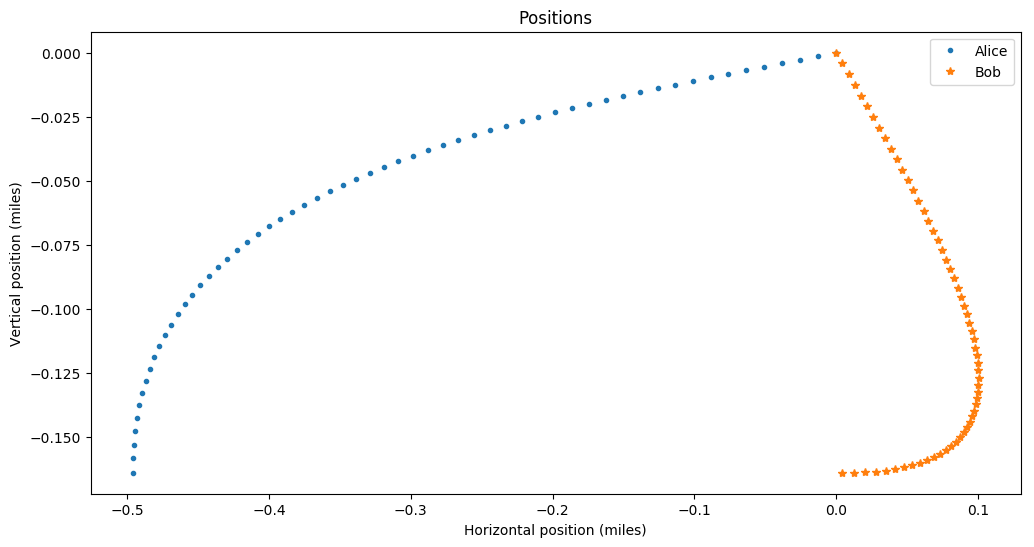

The optimal rendezvous position is at (0.0,0.0).


In [3]:
using PyPlot
figure(figsize=(12,6))
title("Positions")
plot( getvalue(x_A[1,:][:]), getvalue(x_A[2,:][:]), ".")
plot( getvalue(x_B[1,:]), getvalue(x_B[2,:]), "*")
legend(["Alice", "Bob"])
xlabel("Horizontal position (miles)")
ylabel("Vertical position (miles)")
;

println("The optimal rendezvous position is at (", getvalue(x_A[1, T]), ",", getvalue(x_B[2, T]), ").")

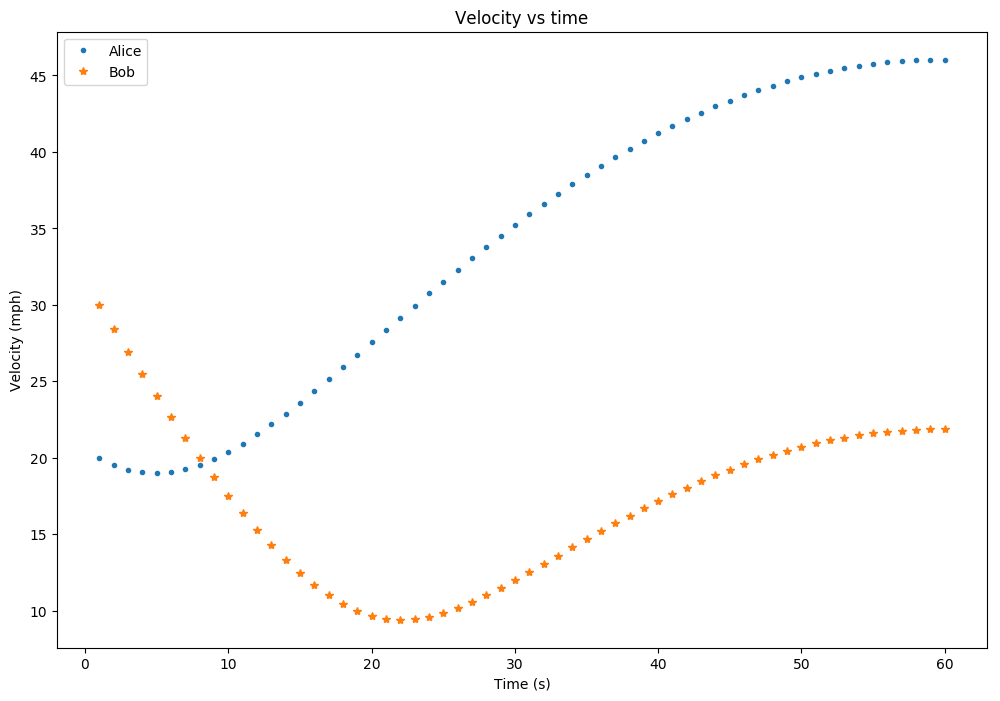

The greatest speed Alice reaches is 46.02778367985958 while Bob's is 30.0


In [4]:
velocity_A = zeros(T)
velocity_B = zeros(T)
for i in 1:T
    velocity_A[i] = norm(getvalue(v_A[:, i]))
    velocity_B[i] = norm(getvalue(v_B[:, i]))
end

figure(figsize=(12,8))
title("Velocity vs time")
plot(t, velocity_A, ".")
plot(t, velocity_B, "*")
legend(["Alice", "Bob"])
xlabel("Time (s)")
ylabel("Velocity (mph)")
;

println("The greatest speed Alice reaches is ", maximum(velocity_A), " while Bob's is ", maximum(velocity_B))

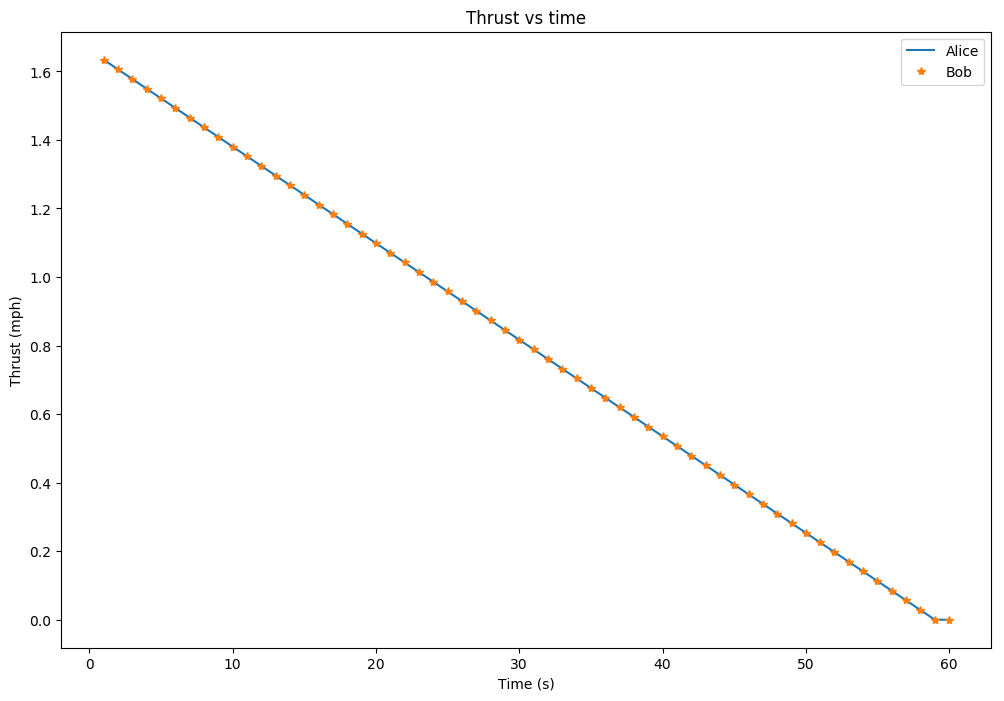

In [5]:
thrust_A = zeros(T)
thrust_B = zeros(T)
for i in 1:T
    thrust_A[i] = norm(getvalue(u_A[:, i]))
    thrust_B[i] = norm(getvalue(u_B[:, i]))
end

figure(figsize=(12,8))
title("Thrust vs time")
plot(t, thrust_A, "-")
plot(t, thrust_B, "*")
legend(["Alice", "Bob"])
xlabel("Time (s)")
ylabel("Thrust (mph)")
;

__b)__ In addition to arriving at the same place at the same time, Alice and Bob should also make sure their velocity vectors match when they rendezvous (otherwise, they might crash!) Solve the rendezvous problem again with the additional velocity matching constraint and plot the resulting trajectories. Is the optimal rendezvous location different from the one found in the first part?

In [6]:
T = 60
t = [1:T;]

using JuMP, Mosek, Gurobi

m2 = Model(solver = GurobiSolver(OutputFlag=0))

# position
@variable(m2, x_A[1:2, 1:T])
@variable(m2, x_B[1:2, 1:T])

# velocity
@variable(m2, v_A[1:2, 1:T])
@variable(m2, v_B[1:2, 1:T])

# thrust
@variable(m2, u_A[1:2, 1:T])
@variable(m2, u_B[1:2, 1:T])

# at t = 1, Alice has a speed of 20mph going North
@constraint(m2, v_A[:, 1] .== [0; 20])
# at t = 1, Bob has a speed of 30mph going East
@constraint(m2, v_B[:, 1] .== [30; 0])

# at t = 1, Bob is 0.5 miles East of Alice
@constraint(m2, x_B[:, 1] .== x_A[:, 1] + [0.5; 0])

# Alice and Bob want to meet at t = 60
@constraint(m2, x_A[:, T] .== x_B[:, T])
# And their velocity vectors must match here
@constraint(m2, v_A[1, T] == v_B[1, T])
@constraint(m2, v_A[2, T] == v_B[2, T])

# satisfy the dynamics
for i = 1:T-1
    @constraint(m2, x_A[:, i+1] .== x_A[:, i] + (1/3600)v_A[:, i])
    @constraint(m2, x_B[:, i+1] .== x_B[:, i] + (1/3600)v_B[:, i])

    @constraint(m2, v_A[:, i+1] .== v_A[:, i] + u_A[:, i])
    @constraint(m2, v_B[:, i+1] .== v_B[:, i] + u_B[:, i])
end

# minimize 2-norm
@expression(m2, E_A, sum(u_A.^2))
@expression(m2, E_B, sum(u_B.^2))
@objective(m2, Min, E_A + E_B)
                 
println(solve(m2))
println("Total energy used = ", getobjectivevalue(m2))

Optimal
Total energy used = 234.57042665108122


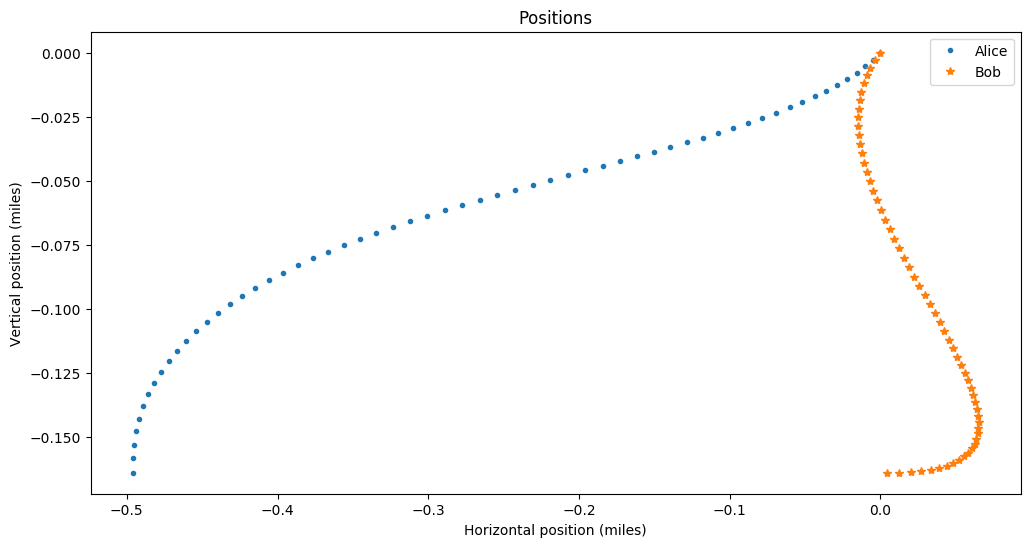

The optimal rendezvous position is at (0.0,0.0).


In [8]:
using PyPlot

figure(figsize=(12,6))
title("Positions")
plot( getvalue(x_A[1,:][:]), getvalue(x_A[2,:][:]), ".")
plot( getvalue(x_B[1,:]), getvalue(x_B[2,:]), "*")
legend(["Alice", "Bob"])
xlabel("Horizontal position (miles)")
ylabel("Vertical position (miles)")
;

println("The optimal rendezvous position is at (", getvalue(x_A[1, T]), ",", getvalue(x_B[2, T]), ").")


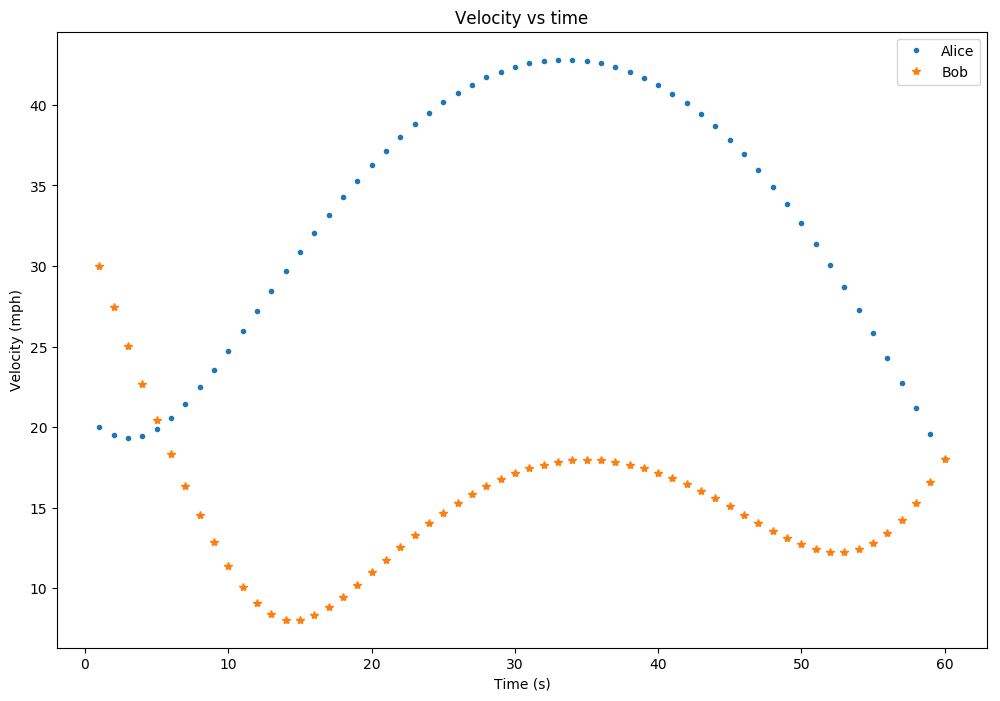

The greatest speed Alice reaches is 42.79755747657694 while Bob's is 30.0


In [9]:
velocity_A = zeros(T)
velocity_B = zeros(T)
for i in 1:T
    velocity_A[i] = norm(getvalue(v_A[:, i]))
    velocity_B[i] = norm(getvalue(v_B[:, i]))
end

figure(figsize=(12,8))
title("Velocity vs time")
plot(t, velocity_A, ".")
plot(t, velocity_B, "*")
legend(["Alice", "Bob"])
xlabel("Time (s)")
ylabel("Velocity (mph)")
;

println("The greatest speed Alice reaches is ", maximum(velocity_A), " while Bob's is ", maximum(velocity_B))

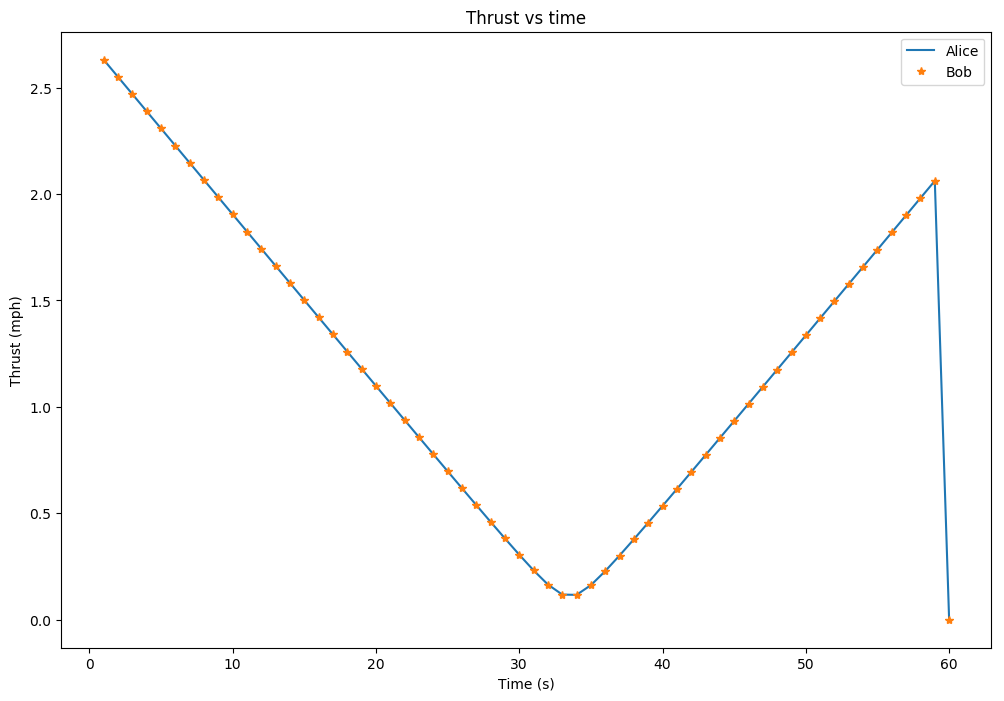

In [10]:
thrust_A = zeros(T)
thrust_B = zeros(T)
for i in 1:T
    thrust_A[i] = norm(getvalue(u_A[:, i]))
    thrust_B[i] = norm(getvalue(u_B[:, i]))
end

figure(figsize=(12,8))
title("Thrust vs time")
plot(t, thrust_A, "-")
plot(t, thrust_B, "*")
legend(["Alice", "Bob"])
xlabel("Time (s)")
ylabel("Thrust (mph)")
;

__Note: The optimal rendezvous point has not shifted at all, in the model with the velocity constraint.__

In the first model,

> The optimal rendezvous position is at (0.0,0.0).

And identically in the second model,

> The optimal rendezvous position is at (0.0,0.0).

__c)__ Alice and Bob forgot about one important detail. The hovercrafts each have a top speed of 35 mph. The solutions found in the previous parts are unacceptable because they require Alice to exceed the maximum allowable speed. First, verify that this is indeed the case. Second, explain how to alter your model to account for the speed limit. Finally, solve the rendezvous problem one
last time with all the constraints in place and verify that your solution respects the speed limit.

__Answer__

In the first model,

> The greatest speed Alice reaches is 46.02778367985958 while Bob's is 30.0

And in the second model,

> The greatest speed Alice reaches is 42.79755747657694 while Bob's is 30.0

In both models, Alice needs to be travelling at > 35mph which we now know is not possible. 

To account for the speed limit, we could simply add a constraint that norm of the velocity vector at any point in time not exceed 35mph. 

In [11]:
T = 60
t = [1:T;]

using JuMP, Mosek, Gurobi

m3 = Model(solver = GurobiSolver(OutputFlag=0))

# position
@variable(m3, x_A[1:2, 1:T])
@variable(m3, x_B[1:2, 1:T])

# velocity
@variable(m3, v_A[1:2, 1:T])
@variable(m3, v_B[1:2, 1:T])

# thrust
@variable(m3, u_A[1:2, 1:T])
@variable(m3, u_B[1:2, 1:T])

# at t = 1, Alice has a speed of 20mph going North
@constraint(m3, v_A[:, 1] .== [0; 20])
# at t = 1, Bob has a speed of 30mph going East
@constraint(m3, v_B[:, 1] .== [30; 0])

# at t = 1, Bob is 0.5 miles East of Alice
@constraint(m3, x_B[:, 1] .== x_A[:, 1] + [0.5; 0])

# Alice and Bob want to meet at t = 60
@constraint(m3, x_A[:, T] .== x_B[:, T])
# And their velocity vectors must match here
@constraint(m3, v_A[1, T] == v_B[1, T])
@constraint(m3, v_A[2, T] == v_B[2, T])

# The maximum velocity that the hovercraft can travel at is 35mph
for i in 1:T
    @constraint(m3, v_A[1, i]^2 + v_A[2, i]^2 <= 35^2)
    @constraint(m3, v_B[1, i]^2 + v_B[2, i]^2 <= 35^2)
end

# satisfy the dynamics
for i = 1:T-1
    @constraint(m3, x_A[:, i+1] .== x_A[:, i] + (1/3600)v_A[:, i])
    @constraint(m3, x_B[:, i+1] .== x_B[:, i] + (1/3600)v_B[:, i])

    @constraint(m3, v_A[:, i+1] .== v_A[:, i] + u_A[:, i])
    @constraint(m3, v_B[:, i+1] .== v_B[:, i] + u_B[:, i])
end

# minimize 2-norm
@expression(m3, E_A, sum(u_A.^2))
@expression(m3, E_B, sum(u_B.^2))
@objective(m3, Min, E_A + E_B)
                 
println(solve(m3))
println("Total energy used = ", getobjectivevalue(m3))

Optimal
Total energy used = 238.10471928271227


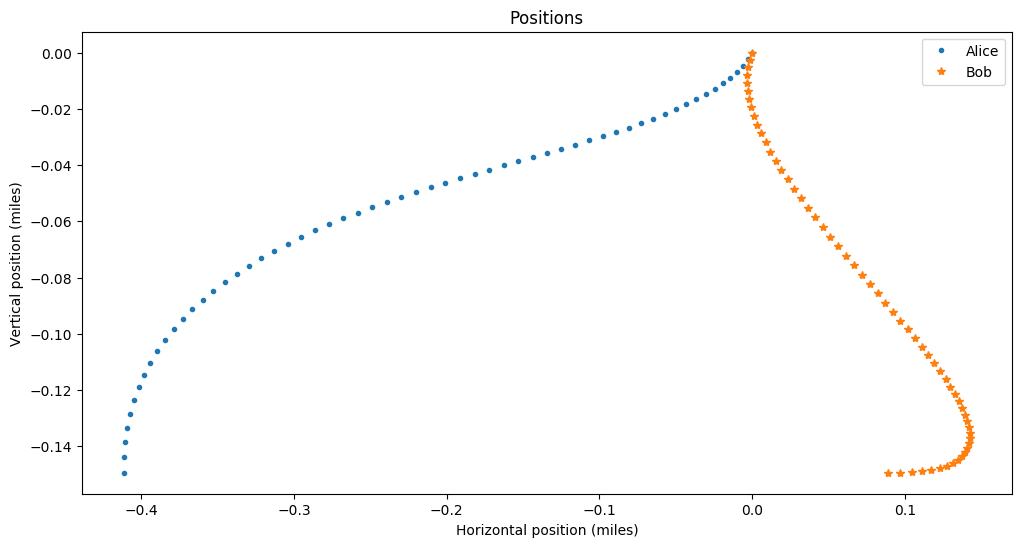

The optimal rendezvous position is at (0.0,0.0).


In [12]:
using PyPlot

figure(figsize=(12,6))
title("Positions")
plot( getvalue(x_A[1,:][:]), getvalue(x_A[2,:][:]), ".")
plot( getvalue(x_B[1,:]), getvalue(x_B[2,:]), "*")
legend(["Alice", "Bob"])
xlabel("Horizontal position (miles)")
ylabel("Vertical position (miles)")
;

println("The optimal rendezvous position is at (", getvalue(x_A[1, T]), ",", getvalue(x_B[2, T]), ").")

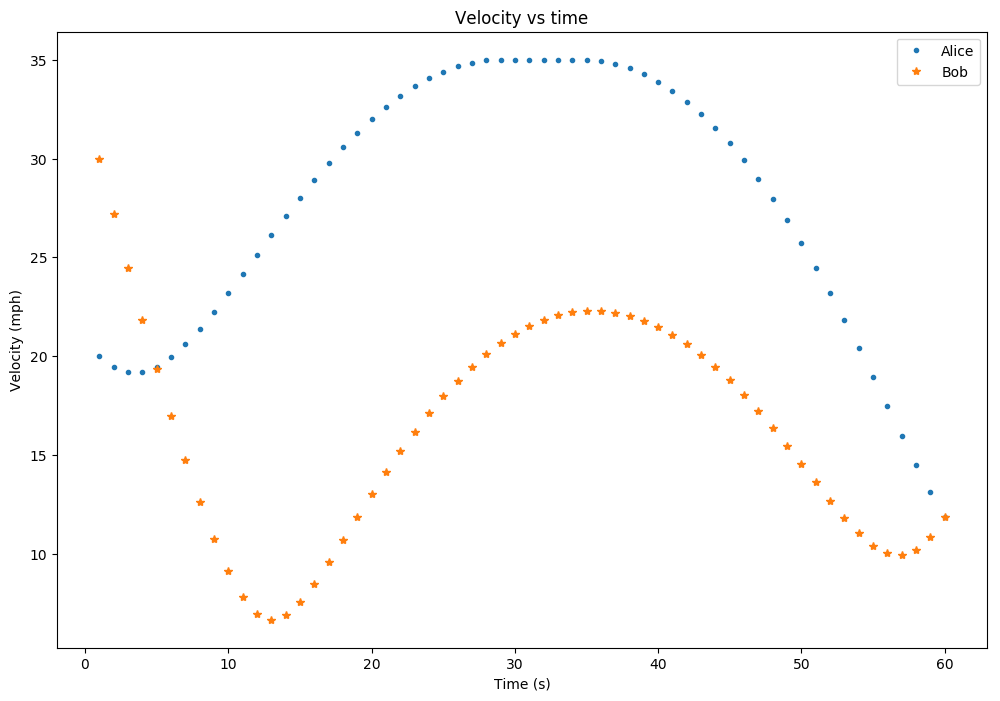

The greatest speed Alice reaches is 34.99999665863911 while Bob's is 30.0


In [13]:
velocity_A = zeros(T)
velocity_B = zeros(T)
for i in 1:T
    velocity_A[i] = norm(getvalue(v_A[:, i]))
    velocity_B[i] = norm(getvalue(v_B[:, i]))
end

figure(figsize=(12,8))
title("Velocity vs time")
plot(t, velocity_A, ".")
plot(t, velocity_B, "*")
legend(["Alice", "Bob"])
xlabel("Time (s)")
ylabel("Velocity (mph)")
;

println("The greatest speed Alice reaches is ", maximum(velocity_A), " while Bob's is ", maximum(velocity_B))

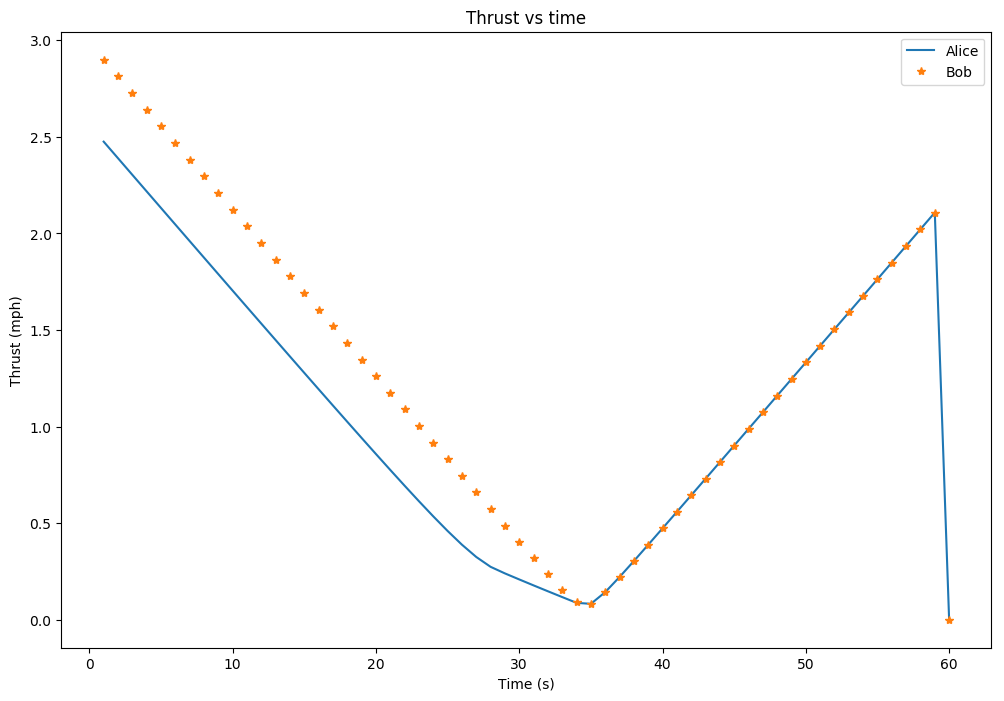

In [14]:
thrust_A = zeros(T)
thrust_B = zeros(T)
for i in 1:T
    thrust_A[i] = norm(getvalue(u_A[:, i]))
    thrust_B[i] = norm(getvalue(u_B[:, i]))
end

figure(figsize=(12,8))
title("Thrust vs time")
plot(t, thrust_A, "-")
plot(t, thrust_B, "*")
legend(["Alice", "Bob"])
xlabel("Time (s)")
ylabel("Thrust (mph)")
;

__The solution respects the speed limit!__